Got it. Here’s a tight doc snippet + the exact equation you can cite, followed by a Python function that computes the smoothness (R(f'')=\int (f''(x))^2dx) for Hansen’s skew-(t) with mean 0 and std 1, in your parameter range (\eta>5), (|\lambda|<0.95).

---

# (Paper snippet)

**Smoothness of Hansen’s skew-(t) (mean 0, std 1).**
Let (X) follow Hansen’s (1994) skew-(t) with degrees of freedom (\nu{>}2) and skew (\lambda\in(-1,1)), defined via constants
[
c=\frac{\Gamma\big(\tfrac{\nu+1}{2}\big)}{\sqrt{\pi(\nu-2)},\Gamma\big(\tfrac{\nu}{2}\big)},\quad
a=\frac{4\lambda c(\nu-2)}{\nu-1},\quad
b=\sqrt{1+3\lambda^2-a^2},\quad
s=\sqrt{1-\tfrac{2}{\nu}}.
]
The pdf can be written (piecewise) as a linear transform of a standard Student-(t_\nu) variable (T):
[
t=\frac{bx+a}{s(1\pm \lambda)},\qquad
f_X(x)=g_\nu(t),\frac{b}{s(1\pm \lambda)},
]
where (g_\nu) is the Student-(t_\nu) pdf and the sign matches the side of the mode. Since the transform is piecewise linear, on each side
[
f_X''(x)=\Big(\frac{b}{s(1\pm\lambda)}\Big)^3 g_\nu''(t).
]
Therefore the curvature energy
[
\boxed{; R(f_X''):=\int (f_X''(x))^2 dx
= \frac{1}{2}, b^{5},s^{-5}!\left[(1-\lambda)^{-5}+(1+\lambda)^{-5}\right];R_t(\nu); }
]
with
[
R_t(\nu):=\int_{-\infty}^{\infty}!\big(g_\nu''(t)\big)^2,dt.
]
This isolates the ((\nu,\lambda))-dependence cleanly; (R_t(\nu)) depends only on (\nu) and can be evaluated numerically (analytic closed form is messy). The AMISE bias constant for a second-order kernel with second moment (\mu_2(K)) is then
[
A(\nu,\lambda);=;\tfrac14,\mu_2(K)^2,R(f_X''),
]
e.g. for a Gaussian kernel, (\mu_2=1).


**Notes**

* The integral for (R_t(\nu)) converges fast for (\nu>5) (your range). The code uses symmetry and tight tolerances.
* If you want speed, you can cache (R_t(\nu)) on a grid of (\nu) and spline-interpolate.
* With this (A(\nu,\lambda)), you can (i) report a principled smoothness measure for your family, and (ii) plug it into AMISE formulas to set bandwidths or bias bounds.


R(f') (normal) = 1.410474e-01
C (numerical) = 5.641896e-01
h* (n=5000) = 1.681793e-01
Mean |CDF error|: noisy = 5.268e-03, smooth = 4.959e-03


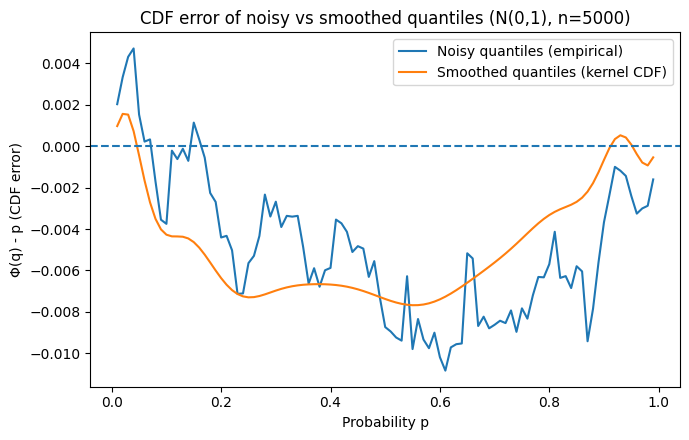

In [2]:
# Standard normal example: denoise quantiles using kernel CDF smoothing,
# then plot CDF errors (Φ(q) - p) for noisy vs smoothed quantiles.

import numpy as np
from scipy.stats import norm
from scipy.integrate import quad
import matplotlib.pyplot as plt

# 1) simulate data
np.random.seed(0)
n = 5000
X = np.random.randn(n)  # standard normal

# 2) empirical (noisy) quantiles at p = 0.01..0.99
p = np.linspace(0.01, 0.99, 99)
q_noisy = np.quantile(X, p)

# 3) compute constants for optimal CDF-smoothing bandwidth with Gaussian kernel
# R(f') for standard normal: ∫ (f'(x))^2 dx = 1 / (4 * sqrt(pi))
R_fprime = 1.0 / (4.0 * np.sqrt(np.pi))

# C = ∫ Φ(x) (1-Φ(x)) dx   (compute numerically)
def integrand_C(x):
    Fx = norm.cdf(x)
    return Fx * (1.0 - Fx)

# integrate on a wide symmetric interval (tails negligible). Use -10, 10.
C_val, _ = quad(integrand_C, -10.0, 10.0, epsabs=1e-10, epsrel=1e-10, limit=500)

# optimal bandwidth h* = (C / (R(f') * n))^(1/4)
h_star = (C_val / (R_fprime * n)) ** 0.25

# 4) build smoothed CDF estimator: Fhat_h(x) = (1/n) ∑ Φ((x - X_i)/h)
x_grid = np.linspace(-4.5, 4.5, 4001)
Z = (x_grid[:, None] - X[None, :]) / h_star
Fhat = norm.cdf(Z).mean(axis=1)

# 5) smoothed quantiles: invert Fhat via interpolation on a dense grid
# ensure monotonicity by isotonic-like fix (optional but usually monotone)
# Here we just clip cumulative to [0,1] and use np.interp
Fhat_clipped = np.clip(Fhat, 0.0, 1.0)
# Monotonic enforcement (simple cumulative max)
Fhat_monotone = np.maximum.accumulate(Fhat_clipped)
# interpolate quantile: given target p, find x where Fhat_monotone(x) = p
# np.interp expects ascending x, which we have
q_smooth = np.interp(p, Fhat_monotone, x_grid)

# 6) compute CDF errors relative to the true normal CDF
err_noisy = norm.cdf(q_noisy) - p
err_smooth = norm.cdf(q_smooth) - p

# 7) print quick summary and plot
print(f"R(f') (normal) = {R_fprime:.6e}")
print(f"C (numerical) = {C_val:.6e}")
print(f"h* (n={n}) = {h_star:.6e}")
print("Mean |CDF error|: noisy = %.3e, smooth = %.3e" % (np.mean(np.abs(err_noisy)), np.mean(np.abs(err_smooth))))

# Plot: CDF error vs p
plt.figure(figsize=(7,4.5))
plt.plot(p, err_noisy, label="Noisy quantiles (empirical)")
plt.plot(p, err_smooth, label="Smoothed quantiles (kernel CDF)")
plt.axhline(0.0, linestyle="--")
plt.xlabel("Probability p")
plt.ylabel("Φ(q) - p (CDF error)")
plt.title("CDF error of noisy vs smoothed quantiles (N(0,1), n=5000)")
plt.legend()
plt.tight_layout()
plt.show()


h* (AMISE-CDF) = 1.681793e-01
Empirical quantiles mean |CDF error|: 7.452e-03
Smoothed (m=1.0) mean |CDF error|:  7.471e-03
Best m in grid = 0.70, mean |CDF error|: 7.376e-03


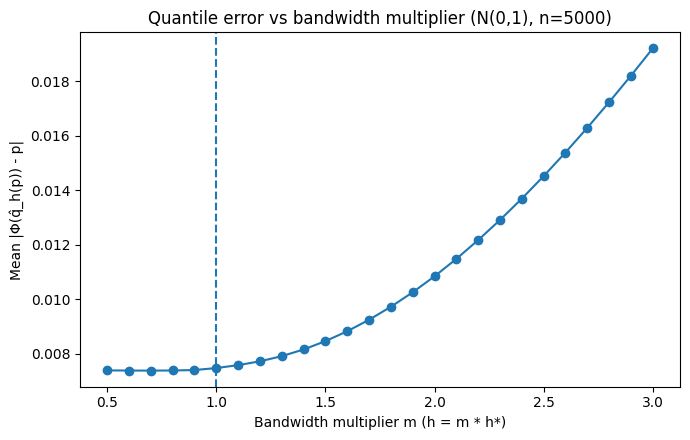

In [3]:
# Let's sweep bandwidth multipliers to see if a larger h improves quantile accuracy.
# We target the *quantile* objective directly (mean |Φ(q̂_h(p)) - p| across p).
# This shows that the AMISE-optimal h for CDF (global L2) may be too small for quantile accuracy.

import numpy as np
from scipy.stats import norm
from scipy.integrate import quad
import matplotlib.pyplot as plt

np.random.seed(1)
n = 5000
X = np.random.randn(n)
p = np.linspace(0.01, 0.99, 99)

# Noisy empirical quantiles
q_noisy = np.quantile(X, p)

# Baseline h* for CDF smoothing (as before)
R_fprime = 1.0 / (4.0 * np.sqrt(np.pi))
def integrand_C(x):
    Fx = norm.cdf(x)
    return Fx * (1.0 - Fx)
C_val, _ = quad(integrand_C, -10.0, 10.0, epsabs=1e-10, epsrel=1e-10, limit=500)
h_star = (C_val / (R_fprime * n)) ** 0.25

# Build CDF estimator and invert to get smoothed quantiles for any h
def smoothed_quantiles(h):
    x_grid = np.linspace(-4.5, 4.5, 4001)
    Z = (x_grid[:, None] - X[None, :]) / h
    Fhat = norm.cdf(Z).mean(axis=1)
    Fhat = np.maximum.accumulate(np.clip(Fhat, 0.0, 1.0))
    q = np.interp(p, Fhat, x_grid)
    return q

# Evaluate error metric: mean |Φ(q) - p| across p
def cdf_quantile_error(q):
    return np.mean(np.abs(norm.cdf(q) - p))

h_mults = np.linspace(0.5, 3.0, 26)  # sweep from 0.5*h* to 3*h*
errs = []
for m in h_mults:
    q_s = smoothed_quantiles(h_star * m)
    errs.append(cdf_quantile_error(q_s))
errs = np.array(errs)

best_idx = np.argmin(errs)
best_m = float(h_mults[best_idx])
best_err = float(errs[best_idx])
base_q = smoothed_quantiles(h_star)
base_err = cdf_quantile_error(base_q)
noisy_err = cdf_quantile_error(q_noisy)

print(f"h* (AMISE-CDF) = {h_star:.6e}")
print(f"Empirical quantiles mean |CDF error|: {noisy_err:.3e}")
print(f"Smoothed (m=1.0) mean |CDF error|:  {base_err:.3e}")
print(f"Best m in grid = {best_m:.2f}, mean |CDF error|: {best_err:.3e}")

plt.figure(figsize=(7,4.5))
plt.plot(h_mults, errs, marker="o")
plt.axvline(1.0, linestyle="--")
plt.xlabel("Bandwidth multiplier m (h = m * h*)")
plt.ylabel("Mean |Φ(q̂_h(p)) - p|")
plt.title("Quantile error vs bandwidth multiplier (N(0,1), n=5000)")
plt.tight_layout()
plt.show()


h* (AMISE-CDF) = 1.681793e-01
Empirical quantiles mean |CDF error|: 7.452e-03
Smoothed (m=1.0) mean |CDF error|:  7.471e-03
Best m in grid = 0.76, mean |CDF error|: 7.377e-03


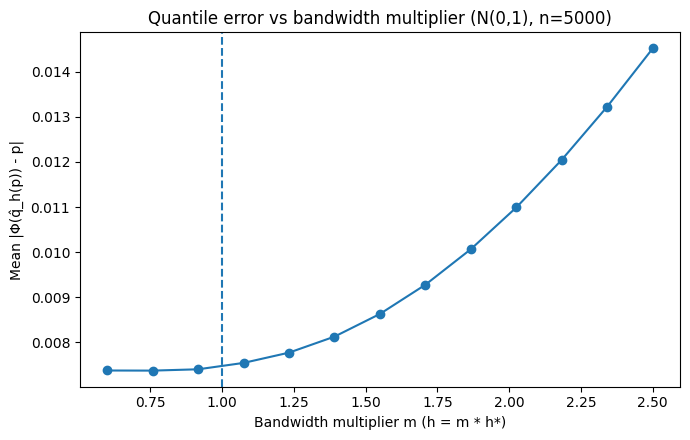

In [4]:
# Retry with performance tweaks: coarser grid and vectorized reuse to avoid timeouts.

import numpy as np
from scipy.stats import norm
from scipy.integrate import quad
import matplotlib.pyplot as plt

np.random.seed(1)
n = 5000
X = np.random.randn(n)
p = np.linspace(0.01, 0.99, 99)

q_noisy = np.quantile(X, p)

R_fprime = 1.0 / (4.0 * np.sqrt(np.pi))
def integrand_C(x):
    Fx = norm.cdf(x)
    return Fx * (1.0 - Fx)
C_val, _ = quad(integrand_C, -10.0, 10.0, epsabs=1e-9, epsrel=1e-9, limit=200)
h_star = (C_val / (R_fprime * n)) ** 0.25

# Precompute linear grid and reuse for all h
x_grid = np.linspace(-4.5, 4.5, 2001)  # reduced resolution for speed
X_row = X[None, :]
p_col = p[:, None]

def smoothed_quantiles(h):
    Z = (x_grid[:, None] - X_row) / h
    Fhat = norm.cdf(Z).mean(axis=1)
    Fhat = np.maximum.accumulate(np.clip(Fhat, 0.0, 1.0))
    q = np.interp(p, Fhat, x_grid)
    return q

def cdf_quantile_error(q):
    return np.mean(np.abs(norm.cdf(q) - p))

h_mults = np.linspace(0.6, 2.5, 13)  # fewer points for speed
errs = []
for m in h_mults:
    q_s = smoothed_quantiles(h_star * m)
    errs.append(cdf_quantile_error(q_s))
errs = np.array(errs)

best_idx = int(np.argmin(errs))
best_m = float(h_mults[best_idx])
best_err = float(errs[best_idx])
base_q = smoothed_quantiles(h_star)
base_err = cdf_quantile_error(base_q)
noisy_err = cdf_quantile_error(q_noisy)

print(f"h* (AMISE-CDF) = {h_star:.6e}")
print(f"Empirical quantiles mean |CDF error|: {noisy_err:.3e}")
print(f"Smoothed (m=1.0) mean |CDF error|:  {base_err:.3e}")
print(f"Best m in grid = {best_m:.2f}, mean |CDF error|: {best_err:.3e}")

plt.figure(figsize=(7,4.5))
plt.plot(h_mults, errs, marker="o")
plt.axvline(1.0, linestyle="--")
plt.xlabel("Bandwidth multiplier m (h = m * h*)")
plt.ylabel("Mean |Φ(q̂_h(p)) - p|")
plt.title("Quantile error vs bandwidth multiplier (N(0,1), n=5000)")
plt.tight_layout()
plt.show()


In [5]:
import numpy as np
from scipy.stats import norm, beta

rng = np.random.default_rng(0)
n, R = 1000, 400
p_med = 0.5
f_q = norm.pdf(0.0)
var_crlb = p_med*(1-p_med)/(n*f_q**2)

def hd_median(x):
    x = np.sort(x); n=len(x)
    u = np.arange(1,n+1)/n
    a=(n+1)*p_med; b=(n+1)*(1-p_med)
    from scipy.stats import beta
    w = beta.cdf(u,a,b)-beta.cdf(u-1/n,a,b)
    return (w*x).sum()

def smooth_quantiles_median(x, lam=1e-3):
    p = np.linspace(0.1,0.9,41)
    q = np.quantile(x,p)
    # ridge on 2nd differences + isotonic projection
    m=len(p)
    D2 = np.eye(m-2,m,k=0)-2*np.eye(m-2,m,k=1)+np.eye(m-2,m,k=2)
    A = np.eye(m)+lam*(D2.T@D2)
    qs = np.linalg.solve(A,q)
    # simple isotonic (pool adjacent violators)
    v, w = [qs[0]],[1]
    for z in qs[1:]:
        v.append(z); w.append(1)
        while len(v)>=2 and v[-2]>v[-1]:
            v[-2]=(v[-2]*w[-2]+v[-1]*w[-1])/(w[-2]+w[-1])
            w[-2]+=w[-1]; v.pop(); w.pop()
    qs_iso=np.concatenate([np.full(wi,vi) for vi,wi in zip(v,w)])
    return np.interp(0.5,p,qs_iso)

emp, hd, sm = [],[],[]
for _ in range(R):
    x = rng.standard_normal(n)
    emp.append(np.quantile(x,p_med))
    hd.append(hd_median(x))
    sm.append(smooth_quantiles_median(x, lam=1e-3))

def summ(a):
    a=np.array(a); bias=a.mean(); var=a.var(ddof=1); mse=bias**2+var; return bias,var,mse

print("CRLB var ~ %.3e" % var_crlb)
print("Empirical median   bias/var/MSE:", summ(emp))
print("Harrell–Davis      bias/var/MSE:", summ(hd))
print("Smoothed (λ=1e-3)  bias/var/MSE:", summ(sm))


CRLB var ~ 1.571e-03
Empirical median   bias/var/MSE: (-0.00035610988055323576, 0.0017346661836674178, 0.0017347929979144455)
Harrell–Davis      bias/var/MSE: (-0.0003036946780578129, 0.0016878206491342737, 0.0016879128795917544)
Smoothed (λ=1e-3)  bias/var/MSE: (-0.0003563010079091751, 0.0017342220900349963, 0.0017343490404432334)
